# Objective

To build multilingual models with English-only training data to find the toxicity among Mutilingual Comments

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment/Train.csv
/kaggle/input/sentiment/Test.csv


## Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow as tf
from tensorflow import keras
from wordcloud import WordCloud, STOPWORDS
import nltk
import warnings
warnings.filterwarnings('ignore')
import random
from transformers import AutoTokenizer, TFAutoModel, AutoModelWithLMHead
from sklearn.model_selection import StratifiedKFold
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


## Detecting TPU

In [3]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


## Reading the Dataset

In [4]:
# Both train datasets contains English Comment Text
train = pd.read_csv("../input/sentiment/Train.csv")
valid = train.sample(frac=0.3,random_state=200)

train=train.drop(valid.index)

test = pd.read_csv("../input/sentiment/Test.csv")

# Validation dataset contains English + Multilingual Comment Text
#valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
# Test Dataset contains Multilingual Content  
#test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
# Sample Submission
#sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv') 

## XLM-Roberta Model

We will be using XLM-Roberta Pretrained Bert model as it performs best on Multilingual Dataset

### Initializing Tokeinzer

In [5]:
tokenizer = AutoTokenizer.from_pretrained("jplu/tf-xlm-roberta-large")

### Preparing function for tokenizing the text

In [6]:
MAX_LEN = 192
def preprocess(data, max_seq_length = MAX_LEN, tokenizer = tokenizer):    
    ids = []
    masks = []
    segment = []
    for i in tqdm(range(len(data))):
        
        tokens = tokenizer.tokenize(data[i])
        if len(tokens) > max_seq_length - 2:
            tokens = tokens[ : max_seq_length - 2]

        # Converting tokens to ids
        input_ids = tokenizer.convert_tokens_to_ids(["[CLS]"] + tokens + ["[SEP]"])
        # Added [CLS] and [SEP] as required to BERT Model

        # Input mask
        input_masks = [1] * len(input_ids)

        # padding upto max length
        padding = max_seq_length - len(input_ids)
        input_ids.extend([0] * padding)
        input_masks.extend([0] * padding)
        segment_ids =[0]* max_seq_length
        
        
        ids.append(input_ids)
        masks.append(input_masks)
        segment.append(segment_ids)
    
    return (np.array(ids), np.array(masks), np.array(segment))

### Getting Train and Test Data ready for Model Input

In [7]:
train['content'] = train['content'].astype(str)
train_ids, train_masks, train_segment =  preprocess(train["content"].values)

In [8]:
test['content'] = test['content'].astype(str)
test_ids, test_masks, test_segment =  preprocess(test["content"].values)

### Getting Labels into one variable

In [9]:
y_train = train['score'].values
y_train

array([ 0,  1, -1, ...,  1,  1, -1])

### Initializing the Batch Size

In [10]:
BATCH_SIZE = 12 * strategy.num_replicas_in_sync

## Defining the Model

In [11]:
def model(roberta_layer, max_len = MAX_LEN):
    input_word_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    pooled_output, sequence_output = roberta_layer([input_word_ids, input_mask, segment_ids])

    # There are two outputs: a pooled_output of shape [batch_size, 768] with representations for 
    # the entire input sequences and a sequence_output of shape [batch_size, max_seq_length, 768] 
    # with representations for each input token (in context)


    x = pooled_output
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(120, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(64, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(32, activation = 'relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    
    model = tf.keras.Model(inputs = [input_word_ids, input_mask, segment_ids], outputs = x)
    
    return model

## Initializing the Model

In [12]:
with strategy.scope():
    roberta_layer = TFAutoModel.from_pretrained("jplu/tf-xlm-roberta-large", trainable = False)
    model = model(roberta_layer)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 192)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 192)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 192)]        0                                            
__________________________________________________________________________________________________
tf_roberta_model (TFRobertaMode ((None, 192, 1024),  559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]            

## Initializing the StratifiedKFold object

In [13]:
skf = StratifiedKFold(n_splits = 4, shuffle = True)
skf.get_n_splits(train_ids, y_train)
skf

StratifiedKFold(n_splits=4, random_state=None, shuffle=True)

## Training the Model

In [14]:
i = 1
preds = []
for train_index, test_index in skf.split(train_ids, y_train):
    print("\n")
    print("#" * 20)
    print(f"FOLD No {i}")
    print("#" * 20)
    
    
    tr_ids = train_ids[train_index]
    tr_masks = train_masks[train_index]
    tr_segment = train_segment[train_index]
    
    vd_ids = train_ids[test_index]
    vd_masks = train_masks[test_index]
    vd_segment = train_segment[test_index]
    
    y_tr = y_train[train_index]
    y_vd = y_train[test_index]
    
    
    history = model.fit(
    (tr_ids, tr_masks, tr_segment), y_tr,epochs=10,batch_size=BATCH_SIZE,validation_data = ((vd_ids, vd_masks, vd_segment), y_vd),
    steps_per_epoch = len(tr_ids)//BATCH_SIZE)

    predictions = model.predict((test_ids, test_masks, test_segment))
    preds.append(predictions)
    
    i += 1
    K.clear_session()




####################
FOLD No 1
####################
Epoch 1/10
324/324 [==============================] - 94s 291ms/step - accuracy: 0.2802 - loss: 0.6474 - val_accuracy: 0.1490 - val_loss: 0.5259
Epoch 2/10
324/324 [==============================] - 46s 143ms/step - accuracy: 0.3041 - loss: 0.5095 - val_accuracy: 0.1741 - val_loss: 0.4428
Epoch 3/10
324/324 [==============================] - 46s 143ms/step - accuracy: 0.3356 - loss: 0.4487 - val_accuracy: 0.2850 - val_loss: 0.3423
Epoch 4/10
324/324 [==============================] - 46s 141ms/step - accuracy: 0.3422 - loss: 0.3432 - val_accuracy: 0.4122 - val_loss: 0.2521
Epoch 5/10
324/324 [==============================] - 46s 143ms/step - accuracy: 0.3581 - loss: 0.2653 - val_accuracy: 0.3113 - val_loss: 0.1802
Epoch 6/10
324/324 [==============================] - 46s 143ms/step - accuracy: 0.3668 - loss: 0.1163 - val_accuracy: 0.3951 - val_loss: 0.0479
Epoch 7/10
324/324 [==============================] - 46s 143ms/step - accur

## Predicting on Test Set

In [15]:
#predictions =  0.25*preds[0] + 0.25*preds[1] + 0.25*preds[2] + 0.25*preds[3]

test["predictions"] = predictions
#test.set_index("id", inplace = True)
test.to_csv("submission_1.csv")

if you encounter this error :

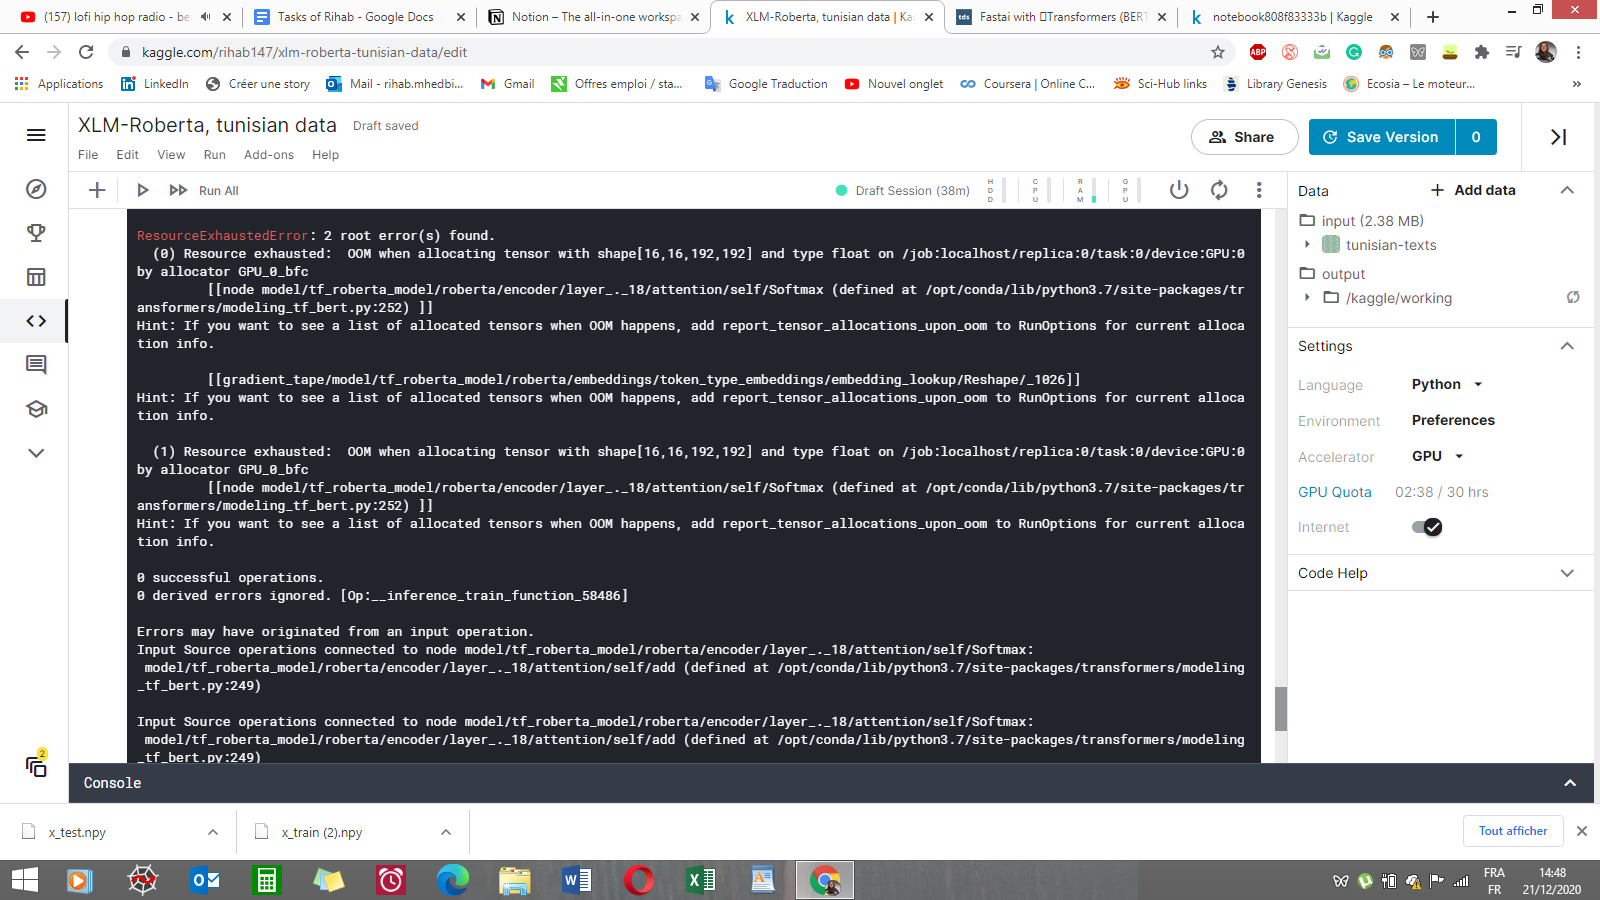  


try one of these solutions https://stackoverflow.com/questions/59394947/how-to-fix-resourceexhaustederror-oom-when-allocating-tensor